/Users/victoriaoberascher/Desktop/autonomousedriving/venv/lib/python3.7/site-packages/ipykernel_launcher.py:289: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


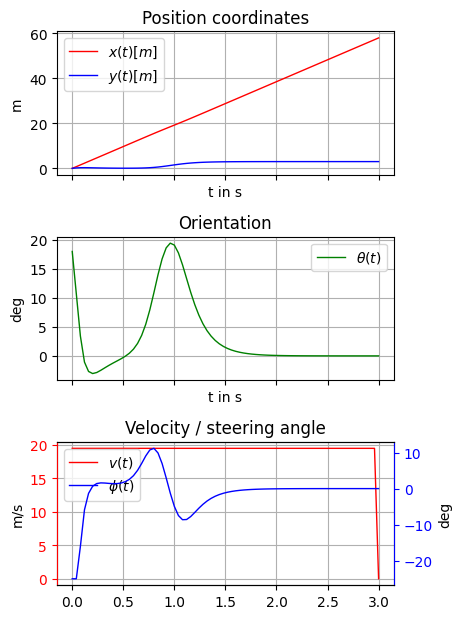

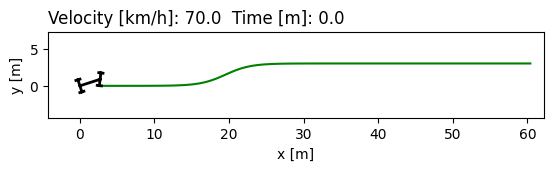

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from numpy import cos, sin, tan, arctan2, pi, arcsin
import scipy.integrate as sci
import matplotlib.pyplot as plt
from matplotlib import animation


from IPython.display import HTML         # for jupyter notebook
plt.rcParams['animation.html'] = 'html5' # for jupyter notebook

class Parameters(object):
    pass


# Physical parameter
para = Parameters()  # instance of class Parameters
para.l = 2.850  # car length in [m]
para.lr = 1.268 / (1.620 + 1.268) * 2.850  # real length [m]
para.lf = 1.620 / (1.620 + 1.268) * 2.850  # front length [m]
para.w = para.l * 0.3  # define car width [m]
para.k = 10  # [1/s] tuning for cross tracking error 1...20 seems reasonable, DARPA 2.5?
para.ksoft = 1.0  # [m/s] to avoid problems as low speeds close or equal to zero
para.dt = 1.0 / 25.0  # controller step size [s]
para.maxDelta = 25 * pi / 180  # [rad]

# Simulation parameter
sim_para = Parameters()  # instance of class Parameters
sim_para.t0 = 0  # start time
sim_para.tf = 3  # final time
sim_para.dt = para.dt  # step-size


def ode(x, t, p):
    """Function of the robots kinematics
    Args:
        x: state  X, Y, Theta
        t: time
        p(object): parameter container class
    Returns:
        dxdt: state derivative
    """
    x1, x2, x3 = x  # state vector
    u1, u2 = p.u  # control(x, t)  # control vector

    # dxdt = f(x, u):
    dxdt = np.array([u1 * cos(x3),
                     u1 * sin(x3),
                     1.0 / p.l * u1 * tan(u2)])

    return dxdt  # return state derivative


def controlStanley(e, xc, p, t):
    """Function of the control law
    Args:
        e: error vector
        xc: state vector of controller (discrete states from last iteration)
        t: time
    Returns:
        u: control vector
        xc: updated state vector controller
    """
    e_fa, theta_e = e  # decompose error

    vx = p.vx
    u1 = vx  # set control vx

    # simple stanley control
    steering_angle = theta_e + arctan2(p.k * e_fa, vx + p.ksoft)

    # normalize and limit
    steering_angle = arcsin(sin(steering_angle))
    steering_angle = np.minimum(np.maximum(steering_angle, -p.maxDelta), p.maxDelta)

    # turn rate
    # turn_rate = vx / p.l * tan( steering_angle )

    return np.array([u1, steering_angle]).T, xc


def plot_data(x, u, r, t, fig_width, fig_height, save=False):
    """Plotting function of simulated state and actions

    Args:
        x(ndarray): state-vector trajectory
        u(ndarray): control vector trajectory
        r(ndarray): reference
        t(ndarray): time vector
        fig_width: figure width in cm
        fig_height: figure height in cm
        save (bool) : save figure (default: False)
    Returns: None

    """
    # creating a figure with 3 subplots, that share the x-axis
    fig1, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

    # set figure size to desired values
    fig1.set_size_inches(fig_width / 2.54, fig_height / 2.54)

    # plot y_1 in subplot 1
    ax1.plot(t, x[:, 0], label='$x(t) [m]$', lw=1, color='r')

    # plot y_2 in subplot 1
    ax1.plot(t, x[:, 1], label='$y(t) [m]$', lw=1, color='b')

    # plot theta in subplot 2
    ax2.plot(t, np.rad2deg(x[:, 2]), label=r'$\theta(t)$', lw=1, color='g')

    # plot control in subplot 3, left axis red, right blue
    ax3.plot(t, u[:, 0], label=r'$v(t)$', lw=1, color='r')
    ax3.tick_params(axis='y', colors='r')
    ax33 = ax3.twinx()
    ax33.plot(t, np.rad2deg(u[:, 1]), label=r'$\phi(t)$', lw=1, color='b')
    ax33.spines["left"].set_color('r')
    ax33.spines["right"].set_color('b')
    ax33.tick_params(axis='y', colors='b')

    # Grids
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)

    # set the labels on the x and y axis and the titles
    ax1.set_title('Position coordinates')
    ax1.set_ylabel(r'm')
    ax1.set_xlabel(r't in s')
    ax2.set_title('Orientation')
    ax2.set_ylabel(r'deg')
    ax2.set_xlabel(r't in s')
    ax3.set_title('Velocity / steering angle')
    ax3.set_ylabel(r'm/s')
    ax33.set_ylabel(r'deg')
    ax33.set_xlabel(r't in s')

    # put a legend in the plot
    ax1.legend()
    ax2.legend()
    ax3.legend()
    li3, lab3 = ax3.get_legend_handles_labels()
    li33, lab33 = ax33.get_legend_handles_labels()
    ax3.legend(li3 + li33, lab3 + lab33, loc=0)

    # automatically adjusts subplot to fit in figure window
    plt.tight_layout()

    # save the figure in the working directory
    if save:
        plt.savefig('CarControl_Stanley2.pdf')  # save output as pdf
        # plt.savefig('CarControl_Stanley2.pgf')  # for easy export to LaTex
    return None


def car_animation(x, u, r, t, p):
    """Animation function of the car-like mobile robot

    Args:
        x(ndarray): state-vector trajectory
        u(ndarray): control vector trajectory
        r(ndarray): reference
        t(ndarray): time vector
        p(object): parameters

    Returns: None

    """
    # Setup two empty axes with enough space around the trajectory so the car
    # can always be completely plotted. One plot holds the sketch of the car,
    # the other the curve
    dx = 1.5 * p.l
    dy = 1.5 * p.l
    fig2, ax = plt.subplots()
    ax.set_xlim([min(min(min(x_traj[:, 0] - dx), -dx), min(r[:, 0])),
                 max(max(max(x_traj[:, 0] + dx), dx), max(r[:, 0]))])
    ax.set_ylim([min(min(min(x_traj[:, 1] - dy), -dy), min(r[:, 1])),
                 max(max(max(x_traj[:, 1] + dy), dy), max(r[:, 1]))])
    ax.set_aspect('equal')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')

    # Axis handles
    h_x_traj_plot, = ax.plot([], [], 'b')  # state trajectory in the y1-y2-plane
    h_xf_traj_plot, = ax.plot([], [], 'r')  # state trajectory in the y1-y2-plane
    h_r_traj_plot, = ax.plot([], [], 'g')
    h_car, = ax.plot([], [], 'k', lw=2)  # car

    def car_plot(x, u):
        """Mapping from state x and action u to the position of the car elements

        Args:
            x: state vector
            u: action vector

        Returns:

        """
        wheel_length = 0.1 * p.l
        y1, y2, theta = x
        v, phi = u

        # define chassis lines
        chassis_y1 = [y1, y1 + p.l * cos(theta)]
        chassis_y2 = [y2, y2 + p.l * sin(theta)]

        # define lines for the front and rear axle
        rear_ax_y1 = [y1 + p.w * sin(theta), y1 - p.w * sin(theta)]
        rear_ax_y2 = [y2 - p.w * cos(theta), y2 + p.w * cos(theta)]
        front_ax_y1 = [chassis_y1[1] + p.w * sin(theta + phi),
                       chassis_y1[1] - p.w * sin(theta + phi)]
        front_ax_y2 = [chassis_y2[1] - p.w * cos(theta + phi),
                       chassis_y2[1] + p.w * cos(theta + phi)]

        # define wheel lines
        rear_l_wl_y1 = [rear_ax_y1[1] + wheel_length * cos(theta),
                        rear_ax_y1[1] - wheel_length * cos(theta)]
        rear_l_wl_y2 = [rear_ax_y2[1] + wheel_length * sin(theta),
                        rear_ax_y2[1] - wheel_length * sin(theta)]
        rear_r_wl_y1 = [rear_ax_y1[0] + wheel_length * cos(theta),
                        rear_ax_y1[0] - wheel_length * cos(theta)]
        rear_r_wl_y2 = [rear_ax_y2[0] + wheel_length * sin(theta),
                        rear_ax_y2[0] - wheel_length * sin(theta)]
        front_l_wl_y1 = [front_ax_y1[1] + wheel_length * cos(theta + phi),
                         front_ax_y1[1] - wheel_length * cos(theta + phi)]
        front_l_wl_y2 = [front_ax_y2[1] + wheel_length * sin(theta + phi),
                         front_ax_y2[1] - wheel_length * sin(theta + phi)]
        front_r_wl_y1 = [front_ax_y1[0] + wheel_length * cos(theta + phi),
                         front_ax_y1[0] - wheel_length * cos(theta + phi)]
        front_r_wl_y2 = [front_ax_y2[0] + wheel_length * sin(theta + phi),
                         front_ax_y2[0] - wheel_length * sin(theta + phi)]

        # empty value (to disconnect points, define where no line should be plotted)
        empty = [np.nan, np.nan]

        # concatenate set of coordinates
        data_y1 = [rear_ax_y1, empty, front_ax_y1, empty, chassis_y1,
                   empty, rear_l_wl_y1, empty, rear_r_wl_y1,
                   empty, front_l_wl_y1, empty, front_r_wl_y1]
        data_y2 = [rear_ax_y2, empty, front_ax_y2, empty, chassis_y2,
                   empty, rear_l_wl_y2, empty, rear_r_wl_y2,
                   empty, front_l_wl_y2, empty, front_r_wl_y2]

        # set data
        h_car.set_data(data_y1, data_y2)

    def init():
        """Initialize plot objects that change during animation.
           Only required for blitting to give a clean slate.

        Returns:

        """
        h_x_traj_plot.set_data([], [])
        h_xf_traj_plot.set_data([], [])
        h_r_traj_plot.set_data([], [])
        h_car.set_data([], [])
        return h_x_traj_plot, h_car, h_xf_traj_plot, h_r_traj_plot

    def animate(i):
        """Defines what should be animated
        Args:
            i: frame number
        Returns:
        """
        k = i % len(t)
        ax.set_title('Velocity [km/h]: ' + str(para.vx * 3.6) + '  Time [m]: ' + str(t[k]), loc='left')
        h_x_traj_plot.set_xdata(x[0:k, 0])
        h_x_traj_plot.set_ydata(x[0:k, 1])
        h_xf_traj_plot.set_xdata(x[0:k, 0] + para.l * cos(x[0:k, 2]))
        h_xf_traj_plot.set_ydata(x[0:k, 1] + para.l * sin(x[0:k, 2]))
        h_r_traj_plot.set_xdata(r[:, 0])
        h_r_traj_plot.set_ydata(r[:, 1])
        car_plot(x[k, :], u[k, :])
        return h_x_traj_plot, h_car, h_xf_traj_plot, h_r_traj_plot

    ani = animation.FuncAnimation(fig2, animate, init_func=init, frames=len(t) + 1,
                                  interval=(t[1] - t[0]) * 1000,
                                  blit=False)

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=1 / (t[1] - t[0]), metadata=dict(artist='Me'), bitrate=1800)
    ani.save('CarControl_Stanley2.mp4', writer=writer)
    return ani


def referenceTrajectory(p, sp):
    # generation of the reference trajectory

    n = np.int((sp.tf - sp.t0) / sp.dt)  # number of samples (here each interval one sample to enable simplified error)
    ds = p.vx * sp.dt  # approximate distance travelled in one time inerval assuming const. vel
    referenceTraj = np.zeros([n, 3])  # reserve space

    k1 = 0.3  # scaling parameter for lane-change (scale tanh input)
    k2 = 5  # offset parameter for lane-change (offset tanh input)
    manouverWidth = 3  # maneuver width in [m]
    for i in np.arange(np.size(referenceTraj, 0)):
        # X
        referenceTraj[i, 0] = i * ds + p.l
        # Y
        referenceTraj[i, 1] = manouverWidth * 0.5 * (np.tanh(ds * i * k1 - k2) + 1)
        # Orientation
        dydx = manouverWidth * 0.5 * k1 / ((np.cosh(k2 - ds * i * k1)) * (np.cosh(k2 - ds * i * k1)))
        referenceTraj[i, 2] = arctan2(dydx, 1)

    return referenceTraj


def controlErrorEGOFront(ego_state, r, t, p):
    # calaculate the error with respect to the front

    x, y, theta = ego_state  # extract state vector from ego_state
    ego_pos = np.array([(x + p.l * cos(theta)), (y + p.l * sin(theta))])  # ego position vector

    target_pos, target_psi = getTargetPoint(ego_pos, r_traj)  # extract target position and orientation

    # POSITION ERROR
    error_vect = ego_pos - target_pos  # vector VA from target to ego
    traj_vect = np.array([cos(target_psi), sin(target_psi)])  # vector VB from target along road
    crossProd_z = error_vect[0] * traj_vect[1] - error_vect[1] * traj_vect[0]  # z of cross VA x VB
    e_fa = np.linalg.norm(target_pos - ego_pos)  # distance error (absolute)
    if crossProd_z < 0:  # check if left or right
        e_fa = -e_fa  # vehicle is left of trajectory

    # ORIENTATION ERROR
    theta_e = target_psi - theta  # orientation error

    return np.array([e_fa, theta_e]).T


def getTargetPoint(x, r):
    # calculate a target point on a polygon r (either a vertex or on a line),
    # that is closest to x

    path_size = np.size(r, 0)

    if path_size == 0:  # polygon is empty --> take x itself
        next_target_position = x[0:2]
        next_target_orientation = x[2]
        return next_target_position, next_target_orientation

    if path_size == 1:  # polygon is size 1 --> take the lonley point
        next_target_position = r[0, 0:2]
        next_target_orientation = r[0, 2]
        return next_target_position, next_target_orientation

    minDist = np.inf  # initial value to find the minimum distance
    P = x[0:2]  # extract position from vehicle

    for i in np.arange(path_size - 1):  # for each segment in the reference polygon r

        A = r[i, 0:2]  # start point of segment
        psi_A = r[i, 2]  # orientation of segment start point
        B = r[i + 1, 0:2]  # end point of segment
        psi_B = r[i + 1, 2]  # orientation of segement end point

        AB = B - A  # segment vector
        d_AB = np.linalg.norm(AB)  # length of segment
        n_AB = 1.0 / d_AB * AB  # segment vector normalized
        t_AB = np.dot((P - A), n_AB)  # dot product of vector from A to P and normalized A to B
        #     = distance of AP projected on AB in direction of AB
        if t_AB >= 0:  # distance is positive --> projection points in direction of segment
            if t_AB <= d_AB:
                next_target_position_Test = A + n_AB * t_AB
                next_target_orientation_Test = psi_A * (1.0 - t_AB / d_AB) + psi_B * t_AB / d_AB
            else:  # projection point is outside of segement AB, closer to B
                next_target_position_Test = B  # therefore the closest target point is A
                next_target_orientation_Test = psi_B
        else:  # projection point is outside of segment AB, closer to A
            next_target_position_Test = A  # therefore the closest target point is A
            next_target_orientation_Test = psi_A

        distance = np.linalg.norm(next_target_position_Test - P)  # calculate distance to closest point on segment

        if i == 0:  # initial case (1st distance is taken)
            minDist = distance
            next_target_position = next_target_position_Test
            next_target_orientation = next_target_orientation_Test

        if distance < minDist:  # check if the distance of the actual segment is less than the smallest known
            minDist = distance
            next_target_position = next_target_position_Test
            next_target_orientation = next_target_orientation_Test

    return next_target_position, next_target_orientation


# initial state ##################################################################
x0 = [0, 0, pi / 10]
para.vx = 70 / 3.6  # vehicle speed

# simulation #####################################################################
tt = np.arange(sim_para.t0, sim_para.tf + sim_para.dt, sim_para.dt)  # time vector

x_traj = np.zeros([len(tt), len(x0)])  # init state trace
x_traj[0, :] = x0  # set initial state
u_traj = np.zeros([len(tt), 2])
xc = [0, 0]  # controller states
e_traj = np.zeros([len(tt), 2])  # init state trace

# reference
r_traj = referenceTrajectory(para, sim_para)

for t_i in np.arange(len(tt) - 1):  # loop over time instances

    # error model
    e_traj[t_i] = controlErrorEGOFront(x_traj[t_i], r_traj, tt[t_i], para)
    # control law
    u, xc = controlStanley(e_traj[t_i], xc, para, tt[t_i])  # get control
    u_traj[t_i] = u
    # vehicle motion
    para.u = u  # to pass control into ode simulation step
    sol = sci.solve_ivp(lambda t, x: ode(x, t, para),
                        (tt[t_i], tt[t_i + 1]), x_traj[t_i, :],
                        method='RK45', t_eval=tt[t_i + 1:t_i + 2])
    x_traj[t_i + 1, :] = sol.y.T  # size = len(x) x len(tt) (.T -> transpose)

# plot ###########################################################################
plot_data(x_traj, u_traj, r_traj, tt, 12, 16, save=True)
plt.show() #for jupyter notepad

# animation ######################################################################
ani = car_animation(x_traj, u_traj, r_traj, tt, para)
HTML(ani.to_html5_video())  #for jupyter notepad
plt.show()


plt.rcParams['figure.dpi'] = 200
ani = car_animation(x_traj, u_traj, r_traj, tt, para)
plt.close()
ani